In [1]:
# import the module
import tweepy
import requests
import textblob
from textblob import TextBlob
from statistics import mean
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import datetime as dt
import yfinance as yf
from dotenv import load_dotenv
import os
from pathlib import Path

In [2]:
# Loads environment variables

load_dotenv()

# These keys are located under Twitter Developer Console 'Projects and Apps'
# You need to create a 'Standalone App' and generate the keys
consumer_key = os.getenv("consumer_key")
consumer_secret = os.getenv("consumer_secret")
access_token = os.getenv("access_token")
access_token_secret = os.getenv("access_token_secret")

# This key is located under Twitter Developer Console 'Products > Premium > Dev Environments'
# You have to create a 'Search Tweets: Full ArchiveSandbox Dev Environment' and use the name of the dev env
twitter_sandbox = os.getenv("twitter_sandbox")

# authorization of consumer key and consumer secret
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  
# set access to user's access key and access secret 
auth.set_access_token(access_token, access_token_secret)
  
# calling the api 
api = tweepy.API(auth)

In [8]:
### Only Run this when ready to start using up Twitter searches. Can load a CSV file down below for testing purposes!!
# Search of Twitter Archive, from start date and incrementing one day at a time. Takes the last 100 tweets of the day.
# Analyses the sentiment of each tweet, creates a list of the individual sentiments, then takes the mean value for the day.
# Creates a list of sentiment values, one value for each day
# Creats one giant list of raw text from all the tweets for the search period for wordcloud generation

searchterms = 'bitcoin'
startdate = dt.datetime(2021, 2, 8)
daterange = 20
yfstartdate = startdate + dt.timedelta(days=1)
yfenddate = startdate + dt.timedelta(days = daterange)

yfstart = yfstartdate.strftime("%Y-%m-%d")
yfend = yfenddate.strftime("%Y-%m-%d")
BTC = yf.Ticker('BTC-USD')
df_BTC = BTC.history(start=yfstart, end=yfend)

daysentiment = []

for i in range(daterange):
        
    fDate = startdate.strftime("%Y%m%d%H%M")
    startdate += dt.timedelta(days=1)
    tDate = startdate.strftime("%Y%m%d%H%M")
    
    results = api.search_full_archive(twitter_sandbox, searchterms, fromDate=fDate, toDate=tDate, maxResults=100)
    
    
    senti = []
    rawtext = []

    for tweet in results[0:100]:
        #print(tweet.text)
        #print(tweet.created_at)
        analysis = TextBlob(tweet.text)
        score = analysis.sentiment.polarity
        #print()
        #print(f"Sentiment= {score}")
        #print()
        senti.append(score)
        rawtext.append(tweet.text)
    
    daysentiment.append(mean(senti))

    
#print(daysentiment)
df_BTC['Sentiment'] = daysentiment

# Save price and sentiment results to CSV
df_BTC.to_csv(f"{searchterms}.csv")

In [ ]:
# Optional Load CSV
filepath = Path('bitcoin.csv')
df_BTC = pd.read_csv(filepath, parse_dates=True, index_col="Date", infer_datetime_format=True)

In [13]:
# Print Results
df_BTC.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Sentiment
Date,,,,,,,,
2021-02-08,38886.828125,46203.929688,38076.324219,46196.464844,101467222687,0,0,0.062842
2021-02-09,46184.992188,48003.722656,45166.960938,46481.105469,91809846886,0,0,0.039114
2021-02-10,46469.761719,47145.566406,43881.152344,44918.183594,87301089896,0,0,0.082648
2021-02-11,44898.710938,48463.468750,44187.761719,47909.332031,81388911810,0,0,0.122292
2021-02-12,47877.035156,48745.734375,46424.976562,47504.851562,76555041196,0,0,0.101058


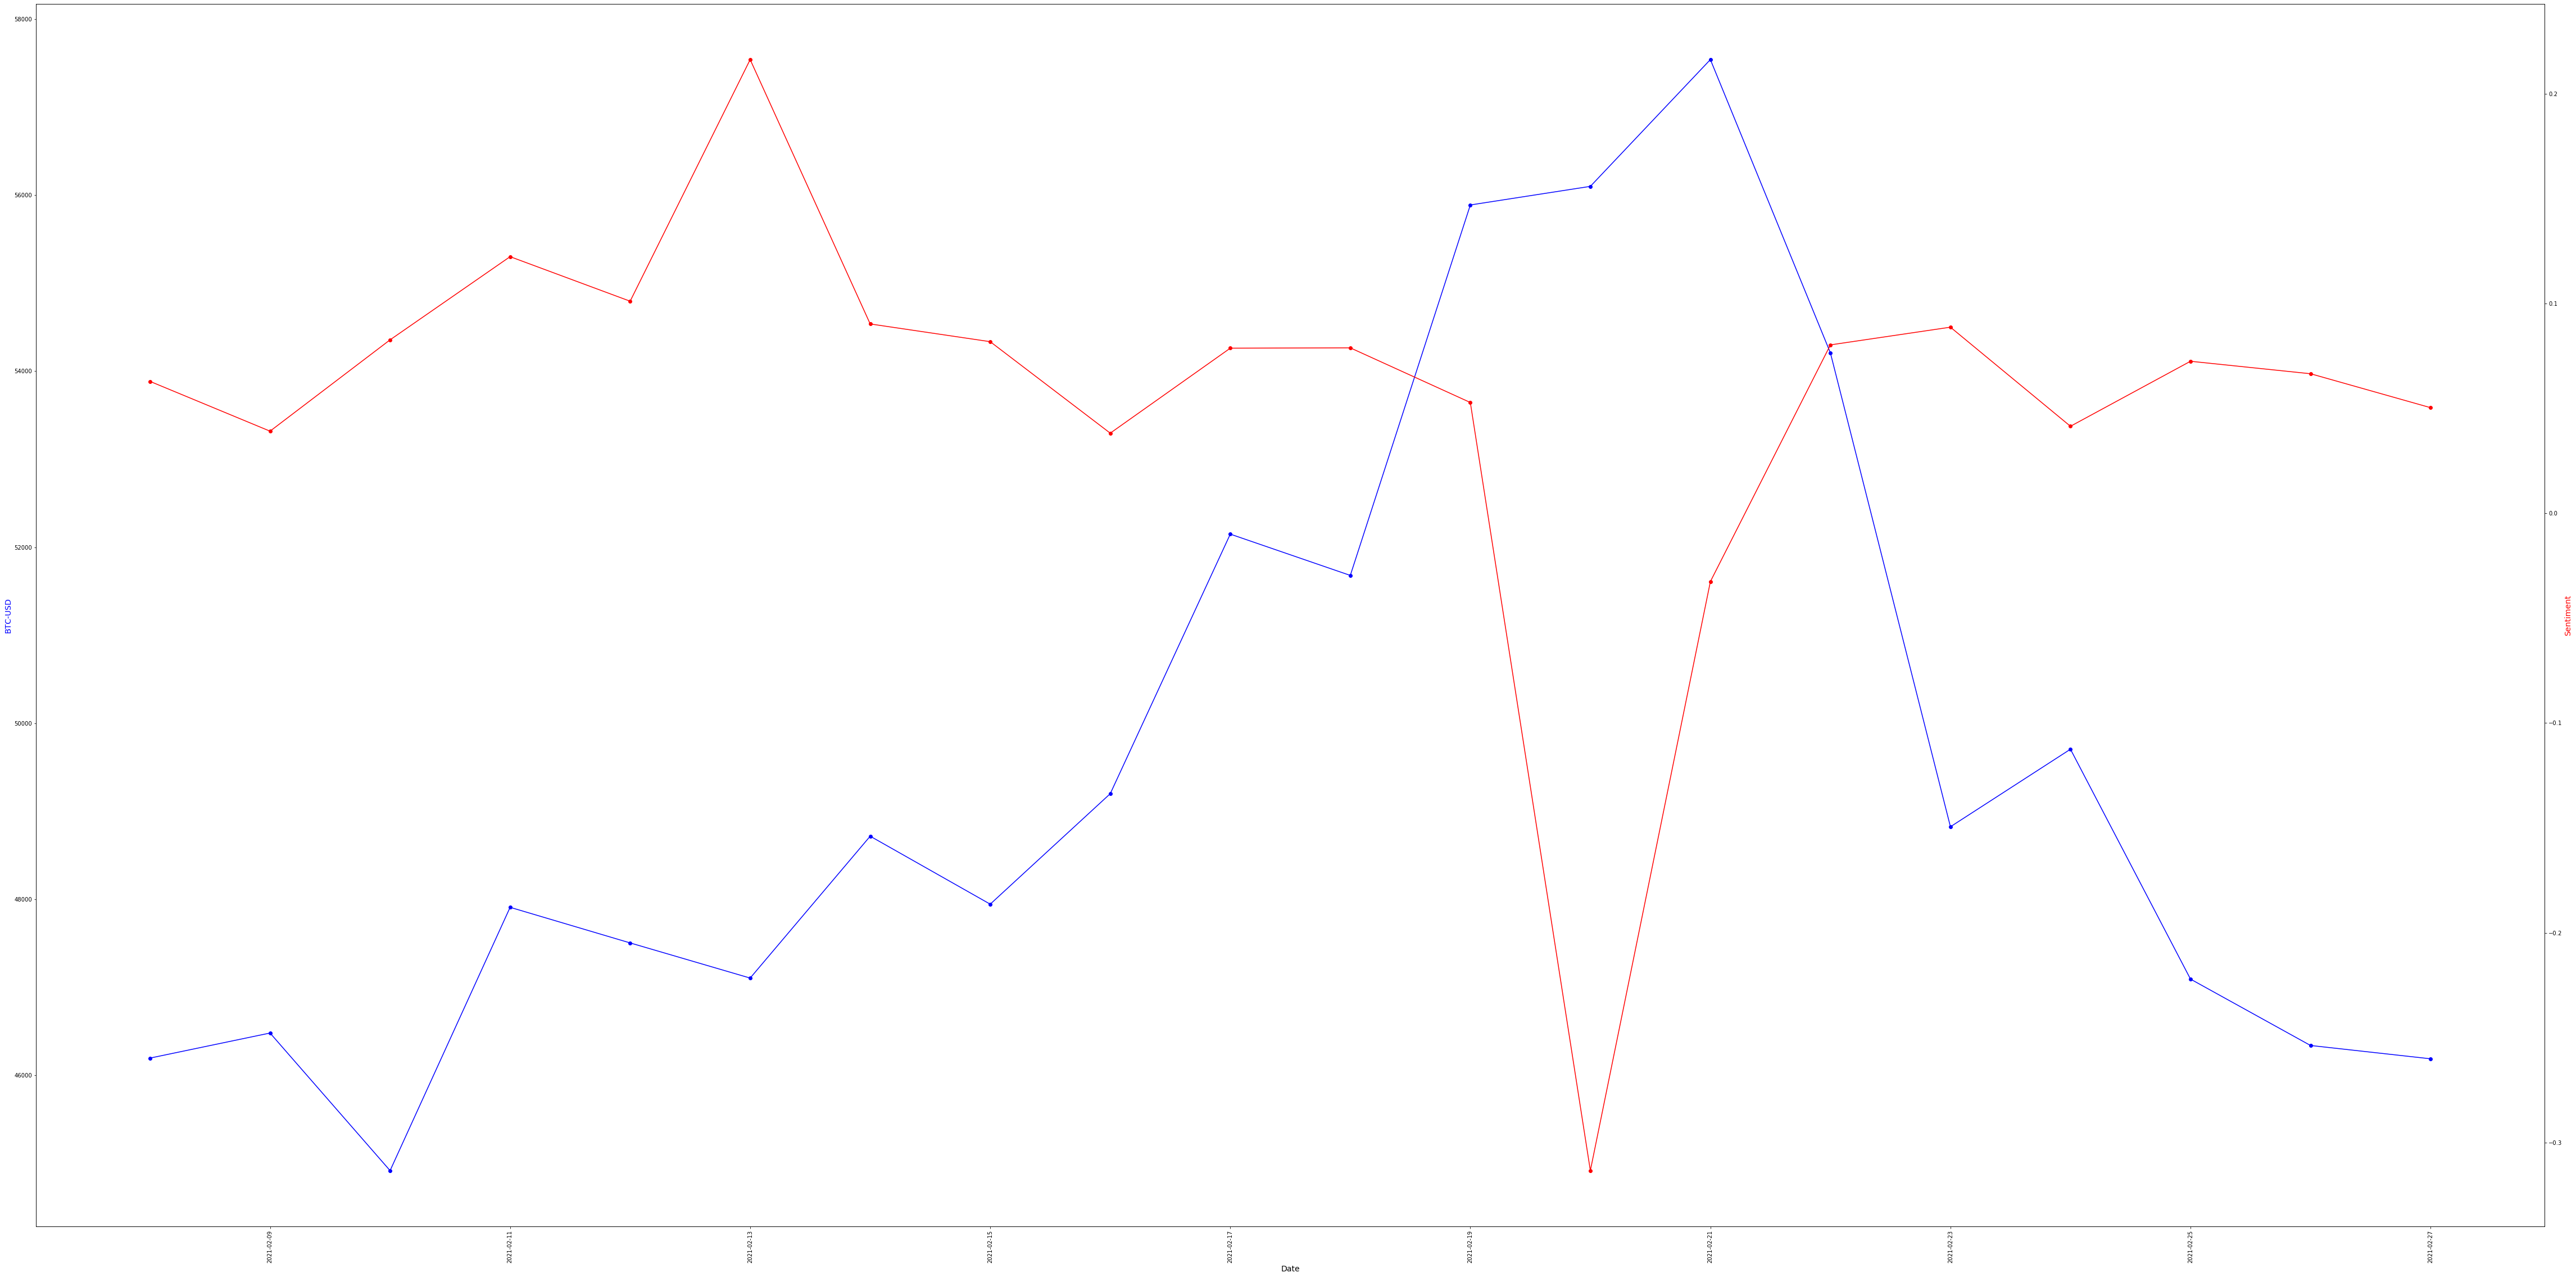

In [45]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(df_BTC.index, df_BTC["Close"], color="blue", marker="o")
# set x-axis label
ax.set_xlabel("Date",fontsize=14)
# set y-axis label
ax.set_ylabel("BTC-USD",color="blue",fontsize=14)
plt.xticks(rotation = 90)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_BTC.index, df_BTC["Sentiment"],color="red",marker="o")
ax2.set_ylabel("Sentiment",color="red",fontsize=14)
plt.rcParams["figure.figsize"] = [80,40]
plt.show()

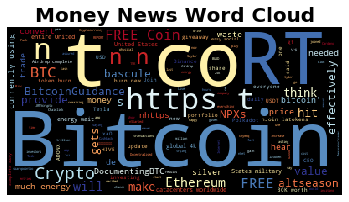

In [26]:
# Generate Wordcloud of search period text

df = pd.DataFrame(rawtext, columns=["Text"])
terms_list = str(df["Text"].tolist())
wordcloud = WordCloud(colormap="RdYlBu").generate(terms_list)
plt.imshow(wordcloud)
plt.axis("off")
fontdict = {"fontsize": 20, "fontweight": "bold"}
plt.title("Money News Word Cloud", fontdict=fontdict)
plt.show()